In [1]:
import sys

sys.path.append(".")

import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from utils import read_msi
from pathlib import Path
from scipy import ndimage
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import MinMaxScaler
from pyimzml.ImzMLParser import ImzMLParser

# Define current folder using this file
CWD = "."
# Define folder that contains the revision chip type dataset
BASE_PATH = Path(os.path.join(CWD, "..", "data", "LONGITUDINAL"))
# Define folder that contains raw data
RAW_DATA = BASE_PATH.joinpath("raw")
# Define folder to save aligned data
ALIGNED_DATA = BASE_PATH.joinpath("aligned")
# Define folder to save processed data
PROCESSED_DATA = BASE_PATH.joinpath("processed")

In [2]:
def read_image_info(folder_name):
  msi_path = PROCESSED_DATA / folder_name / 'meaningful_signal.imzML'
  msi_seg = np.load(PROCESSED_DATA / folder_name / "segmentation_new.npy")

  with ImzMLParser(msi_path) as p:
    mzs, img = read_msi(p)
    mzs_filter = (mzs >= 600) & (mzs <= 900)
    img_filter = img[:, :, mzs_filter]

  return img_filter, mzs[mzs_filter], msi_seg


def plot_clusters(label_image, n_clusters=3):
  #
  tab10_cmap = plt.get_cmap('tab10')
  selected_colors = [tab10_cmap(i) for i in range(n_clusters)]
  colors = np.vstack(([1, 1, 1, 1], selected_colors))
  custom_cmap = ListedColormap(colors)

  #flipped_label_image = np.fliplr(label_image)
  seg_c_map = plt.imshow(label_image, cmap=custom_cmap, vmin=0, vmax=n_clusters)
  cbar = plt.colorbar(
      seg_c_map, ticks=np.arange(1, n_clusters + 1),
      boundaries=np.arange(0.5, n_clusters + 1.5)
  )
  cbar.set_ticklabels(range(1, n_clusters + 1))
  cbar.set_label(
      'Cluster', labelpad=15, fontweight='bold', fontsize=14, color='0.2'
  )
  cbar.outline.set_edgecolor('0.2')
  cbar.ax.tick_params(labelsize=14, width=2.5, color='0.2')
  for l in cbar.ax.get_yticklabels():
    l.set_fontweight('bold')
    l.set_color('0.2')
  plt.axis('off')
  plt.tight_layout()
  plt.show()


def get_sample_name(s):
  if len(s.split("rep_")) > 1:
    return "day_" + s.split("day_")[1].split("_"
                                            )[0] + "_rep_" + s.split("rep_")[1]
  return "day_" + s.split("day_")[1].split("_")[0]

In [3]:
samples_groups = [
    ["tmz_1_tumor_brain_3_day_0_0_uM", "tmz_1_tumor_brain_3_day_5_0_uM_rep_1"],
    [
        "tmz_2_tumor_brain_3_day_0_1000_uM",
        "tmz_2_tumor_brain_3_day_5_1000_uM_rep_2"
    ], ["tmz_tumor_brain_4_day_0_0_uM", "tmz_tumor_brain_4_day_5_0_uM_rep_2"],
    [
        "tmz_tumor_brain_4_day_0_1000_uM",
        "tmz_tumor_brain_4_day_5_1000_uM_rep_2"
    ], ["tmz_tumor_brain_5_day_0_0_uM", "tmz_tumor_brain_5_day_5_0_uM_rep_3"],
    [
        "tmz_2_tumor_brain_5_day_0_1000_uM",
        "tmz_2_tumor_brain_5_day_5_1000_uM_rep_3"
    ], ["tmz_tumor_brain_6_day_0_0_uM", "tmz_tumor_brain_6_day_5_0_uM_rep_3"],
    [
        "tmz_tumor_brain_6_day_0_1000_uM",
        "tmz_tumor_brain_6_day_5_1000_uM_rep_2"
    ]
]

In [4]:
gaussian_sigma = 1.0
n_clusters = 4

img_original_list = []
img_list = []
mzs_list = []
seg_list = []

for sample in np.array(samples_groups).flatten():
  img, mzs, seg = read_image_info(sample)

  img_original_list.append(img)
  mzs_list.append(mzs)
  seg_list.append(seg)

In [5]:
from sklearn.manifold import TSNE


def plot_tsne(data, labels):
  tab10_cmap = plt.get_cmap('tab10')
  selected_colors = [tab10_cmap(i) for i in range(3)]

  # Create and fit the t-SNE model
  tsne = TSNE(n_components=2, random_state=42)
  tsne_result = tsne.fit_transform(data)

  # Create a DataFrame to easily handle the results and labels
  df_tsne = pd.DataFrame(tsne_result, columns=['Component 1', 'Component 2'])

  df_tsne['Label'] = labels

  # Plot the t-SNE results
  plt.figure(figsize=(10, 7))
  for label in sorted(df_tsne['Label'].unique()):
    subset = df_tsne[df_tsne['Label'] == label]
    plt.scatter(
        subset['Component 1'],
        subset['Component 2'],
        label=label,
        #color=selected_colors[int(label) - 1]
    )

  #plt.title('t-SNE plot')
  #plt.xlabel('Component 1')
  #plt.ylabel('Component 2')
  plt.legend()
  plt.show()

In [6]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(np.concatenate([img[seg] for img, seg in zip(img_original_list, seg_list)]))

In [7]:
def plot_embeddings(embeddings, labels):
  tab10_cmap = plt.get_cmap('tab10')
  selected_colors = [tab10_cmap(i) for i in range(3)]

  # Create a DataFrame to easily handle the results and labels
  df_tsne = pd.DataFrame(embeddings, columns=['Component 1', 'Component 2'])

  df_tsne['Label'] = labels

  # Plot the t-SNE results
  plt.figure(figsize=(10, 7))
  for label in sorted(df_tsne['Label'].unique()):
    subset = df_tsne[df_tsne['Label'] == label]
    plt.scatter(
        subset['Component 1'],
        subset['Component 2'],
        label=label,
        #color=selected_colors[int(label) - 1]
    )

  #plt.title('t-SNE plot')
  #plt.xlabel('Component 1')
  #plt.ylabel('Component 2')
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.tight_layout()
  plt.show()

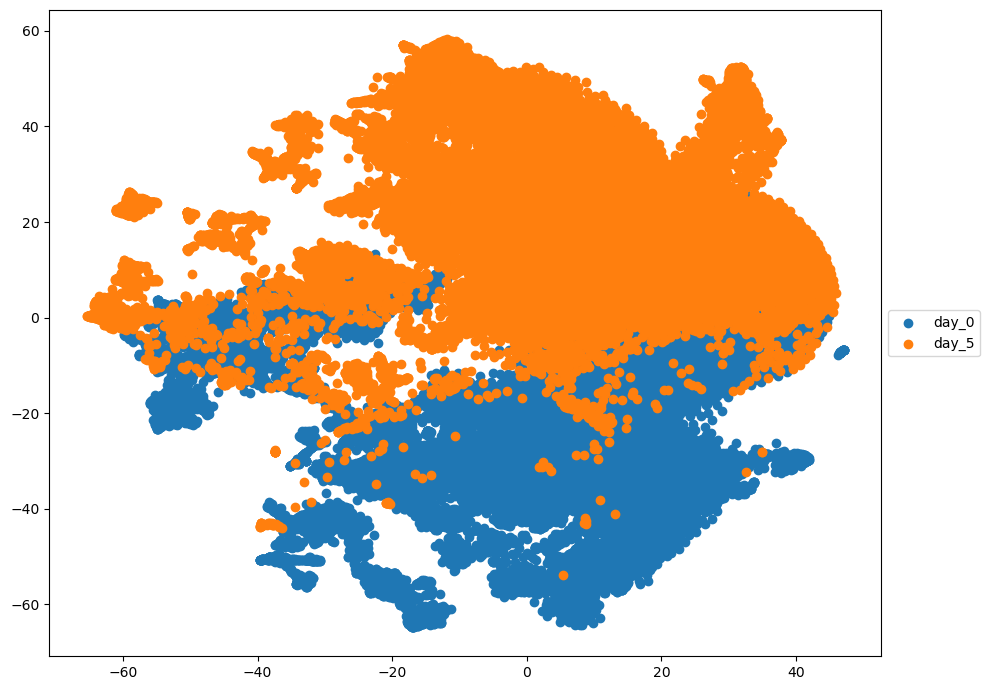

In [8]:
plot_embeddings(tsne_result, np.concatenate([["day_0"] * img[seg].shape[0] if idx % 2 == 0 else ["day_5"] * img[seg].shape[0] for idx, (img, seg) in enumerate(zip(img_original_list, seg_list))]))

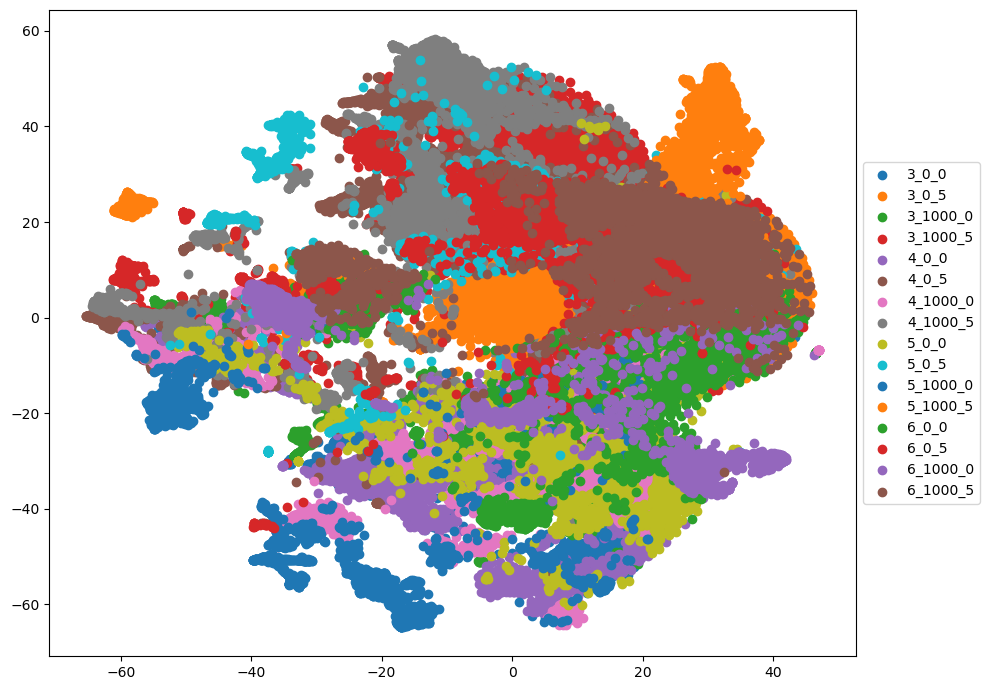

In [11]:
plot_embeddings(tsne_result, np.concatenate([[f"{get_brain_id(sample)}_{get_treatment(sample)}_{get_day(sample)}"] * img[seg].shape[0] for idx, (img, seg, sample) in enumerate(zip(img_original_list, seg_list, np.array(samples_groups).flatten()))]))

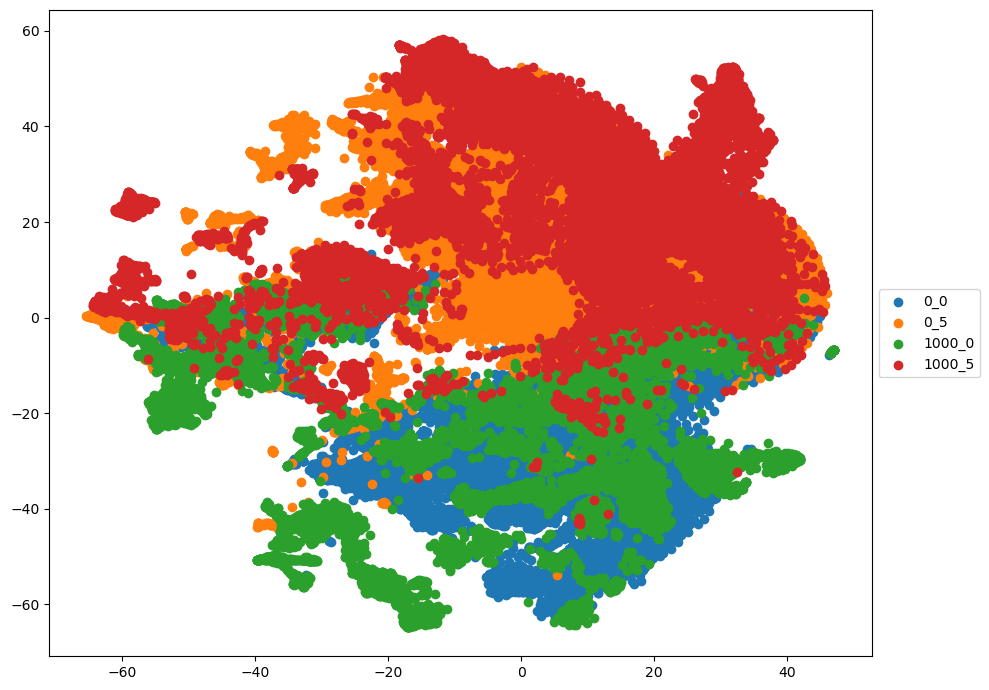

In [12]:
plot_embeddings(tsne_result, np.concatenate([[f"{get_treatment(sample)}_{get_day(sample)}"] * img[seg].shape[0] for idx, (img, seg, sample) in enumerate(zip(img_original_list, seg_list, np.array(samples_groups).flatten()))]))

In [13]:
import joblib
joblib.dump(tsne,  "tsne_meaningful.pkl")

['tsne_meaningful.pkl']

In [8]:
test_tsne = joblib.load("tsne.pkl")

In [12]:
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind, permutation_test, mannwhitneyu, cramervonmises_2samp

means_diff_all = {}
p_values_all = {}

def diff_mean(x, y):
  return np.mean(x) - np.mean(y)

for img_idx in tqdm(range(0, len(samples_groups) * 2, 2)):
  vecs_0 = img_original_list[img_idx][seg_list[img_idx]]
  vecs_5 = img_original_list[img_idx + 1][seg_list[img_idx + 1]]

  p_values = []
  means_diff = []

  for mz_idx, mz in tqdm(enumerate(mzs_list[0])):
    values_0 = vecs_0[:, mz_idx].flatten()
    values_5 = vecs_5[:, mz_idx].flatten()
    t_stat_ind, p_value_ind = ttest_ind(values_0, values_5)
    #t_stat_ind, p_value_ind = mannwhitneyu(values_0, values_5)
    #result = cramervonmises_2samp(values_0, values_5)

    # cramervonmises_2samp

    #result = permutation_test((values_0, values_5), diff_mean, permutation_type='independent', alternative='two-sided', n_resamples=10000, random_state=42)
    #p_value_ind = result.pvalue
    p_values.append(p_value_ind)
    means_diff.append(values_0.mean() - values_5.mean())
  
  p_values_all[img_idx] = p_values
  means_diff_all[img_idx] = means_diff

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [10]:
def get_brain_id(name):
  return name.split("brain_")[1][0]

def get_treatment(name):
  return name.split("day_")[1].split("_")[1]

def get_day(name):
  return name.split("day_")[1][0]

In [14]:
columns = []
for img_idx in tqdm(range(0, len(samples_groups) * 2, 2)):
  sample = np.array(samples_groups).flatten()[img_idx]
  brain, treatment, day = get_brain_id(sample), get_treatment(sample), get_day(sample)
  columns.append(f"{brain}_{treatment}_{day}")

  0%|          | 0/8 [00:00<?, ?it/s]

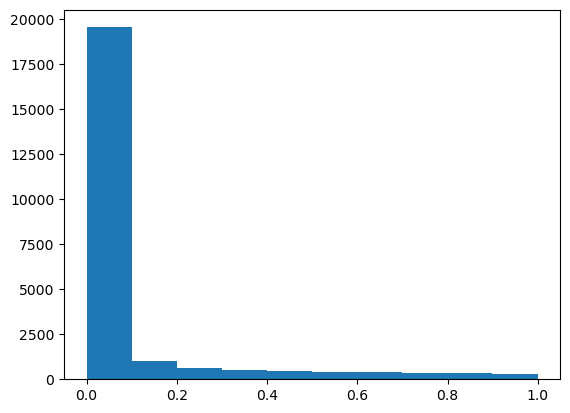

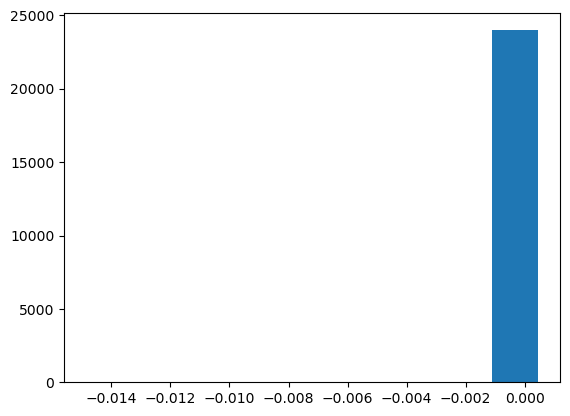

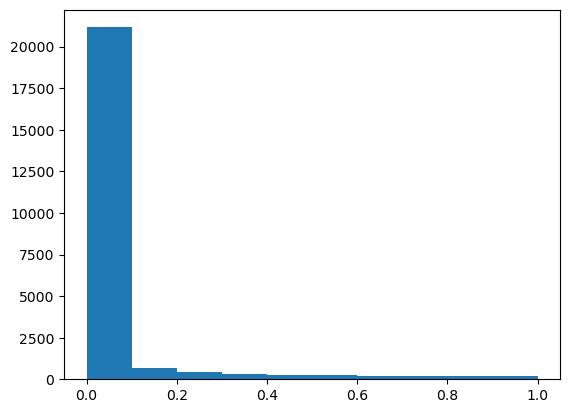

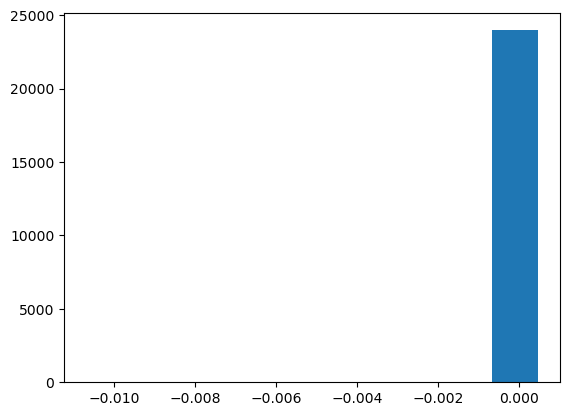

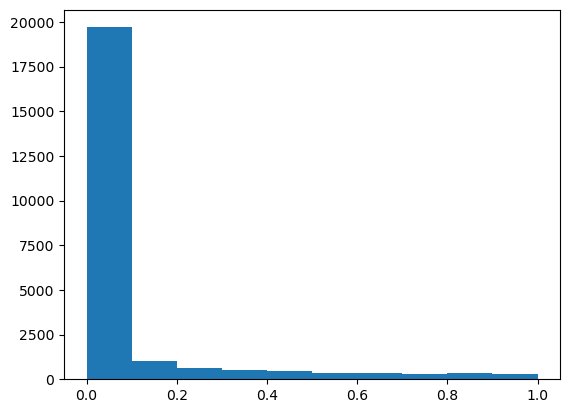

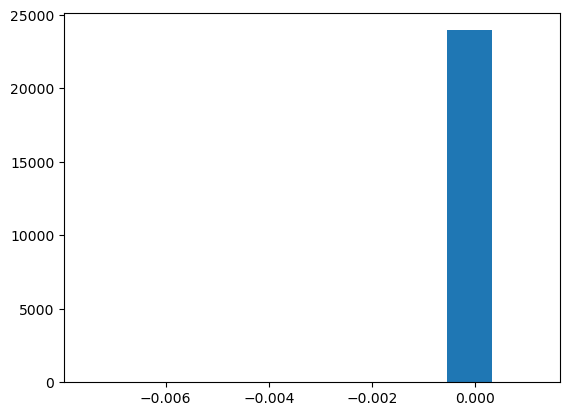

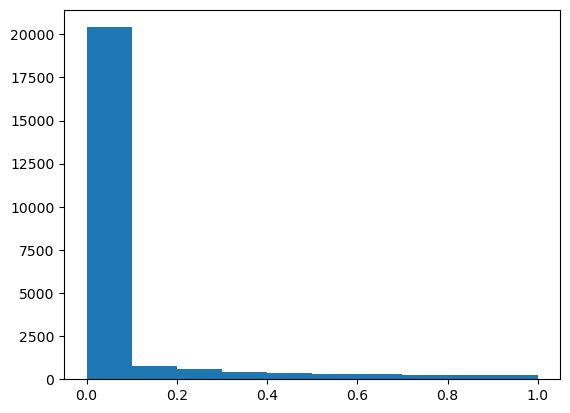

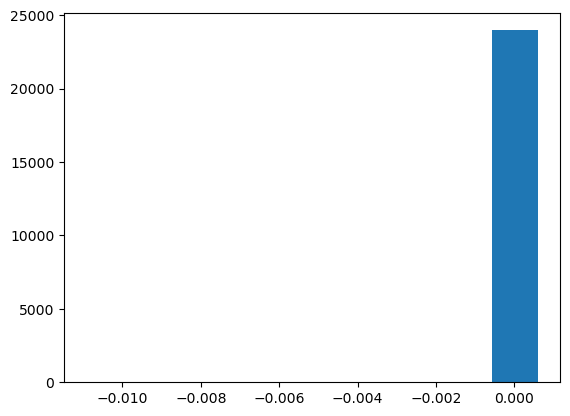

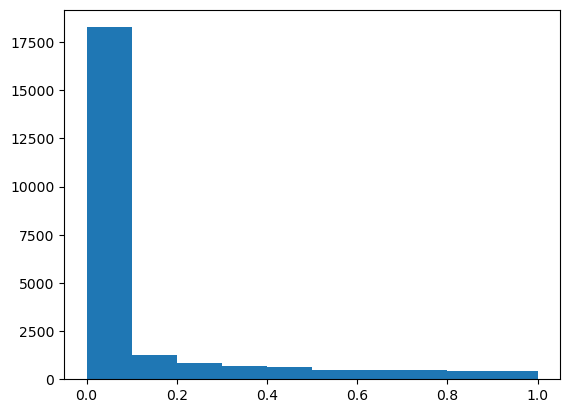

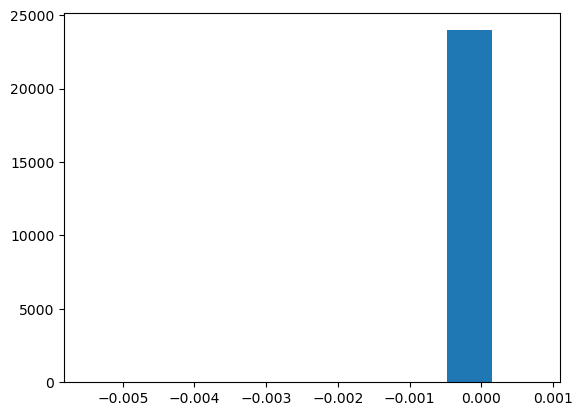

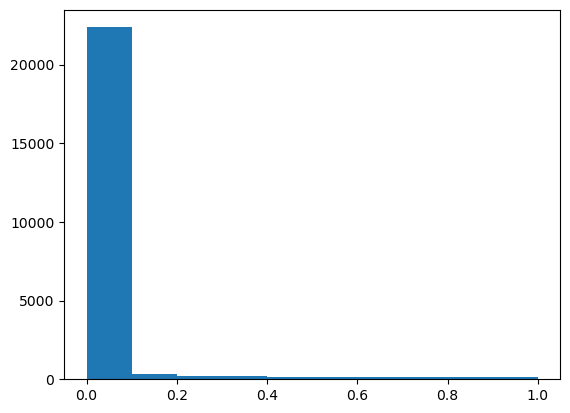

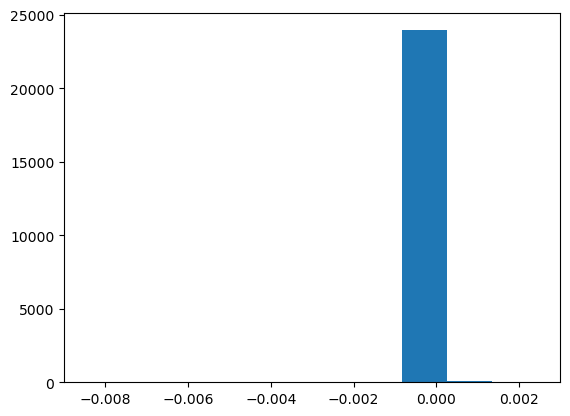

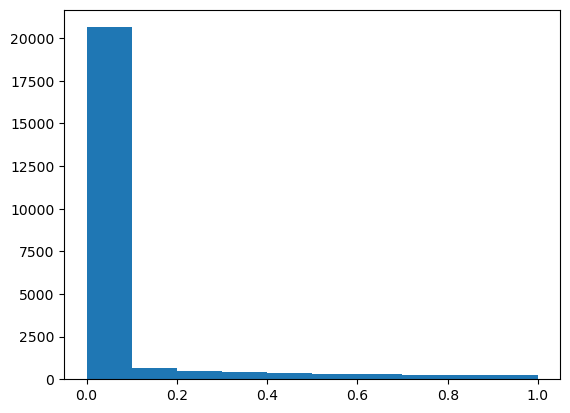

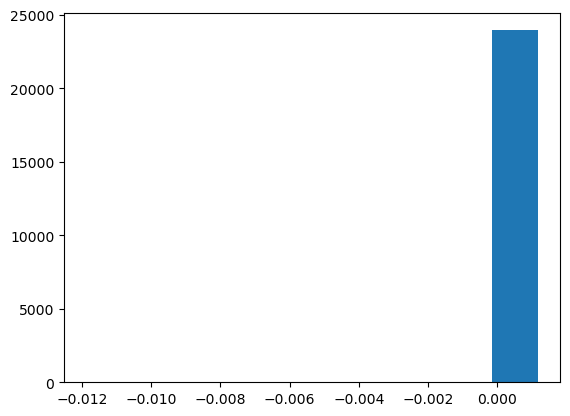

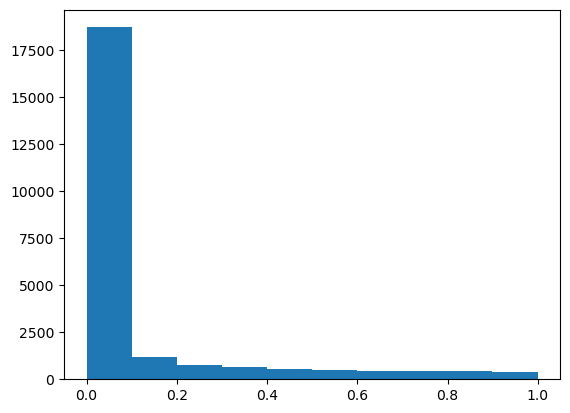

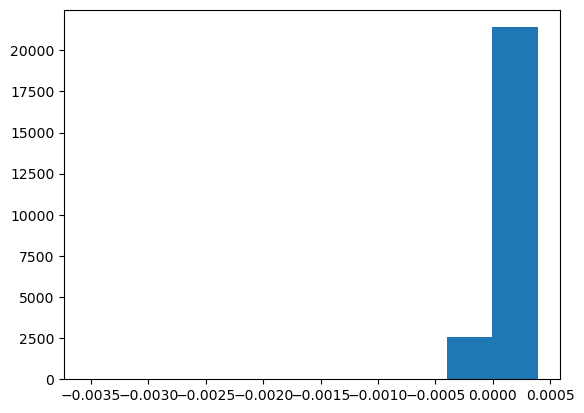

In [16]:
p_values_df = pd.DataFrame(p_values_all, index=mzs_list[0])
p_values_df.columns = p_values_df.columns.map(lambda x: np.array(samples_groups).flatten()[x]).map(lambda x: f"{get_brain_id(x)}_{get_treatment(x)}_{get_day(x)}")

means_diff_df = pd.DataFrame(means_diff_all, index=mzs_list[0])
means_diff_df.columns = means_diff_df.columns.map(lambda x: np.array(samples_groups).flatten()[x]).map(lambda x: f"{get_brain_id(x)}_{get_treatment(x)}_{get_day(x)}")

for column in p_values_df.columns:
  plt.hist(p_values_df[column])
  plt.show()
  plt.hist(means_diff_df[column])
  plt.show()

In [18]:
means_diff_df[column]

1.8881741737424133e-07

  0%|          | 0/8 [00:00<?, ?it/s]

3_0_0


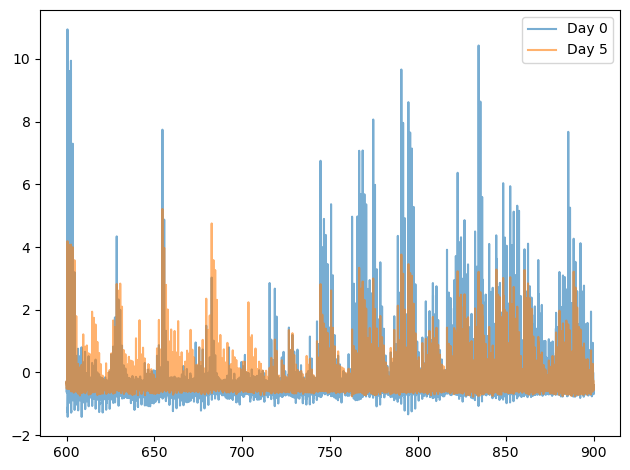

3_1000_0


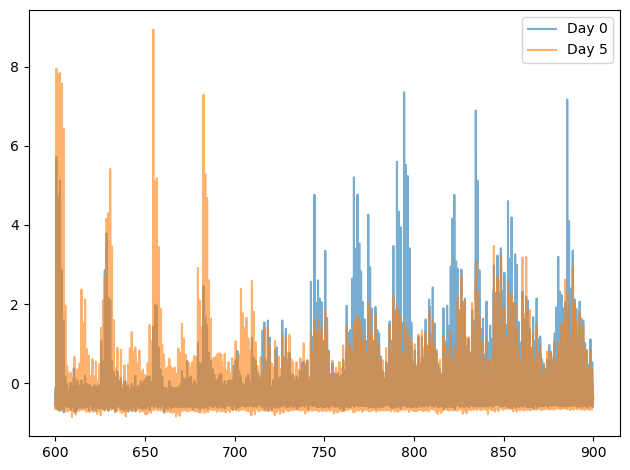

4_0_0


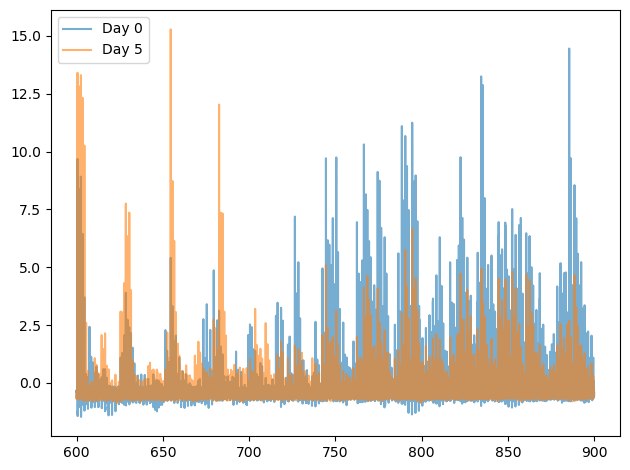

4_1000_0


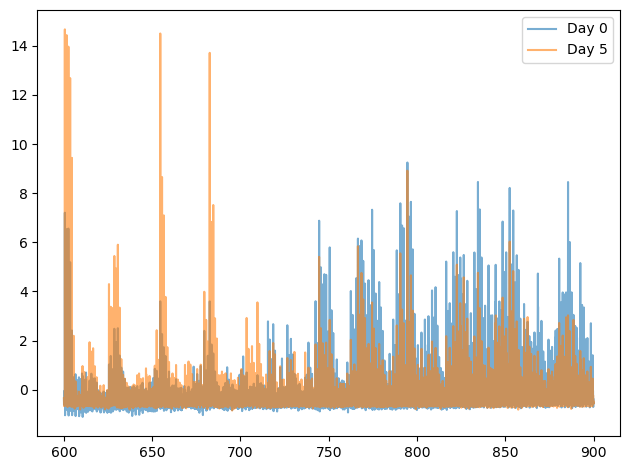

5_0_0


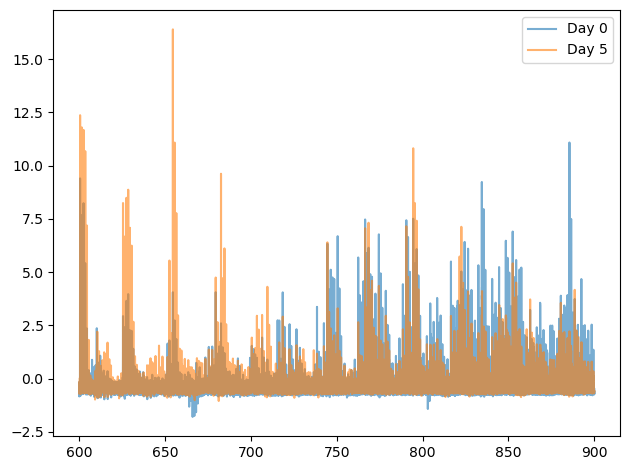

5_1000_0


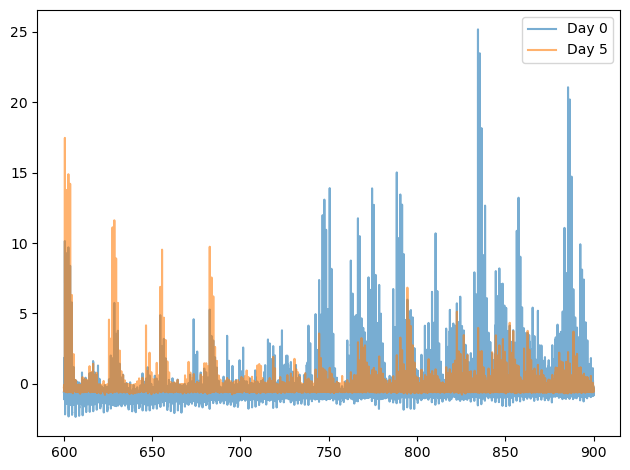

6_0_0


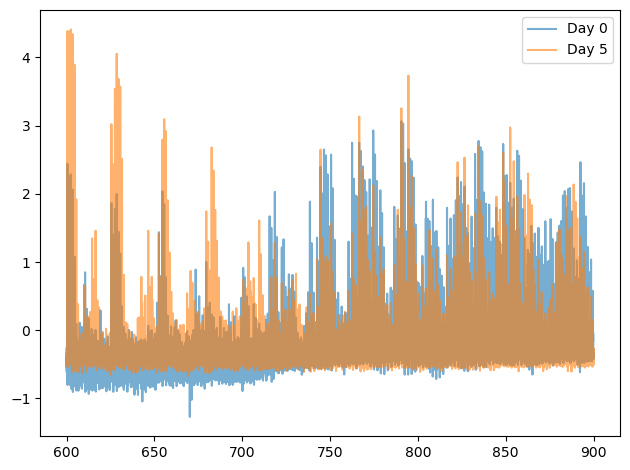

6_1000_0


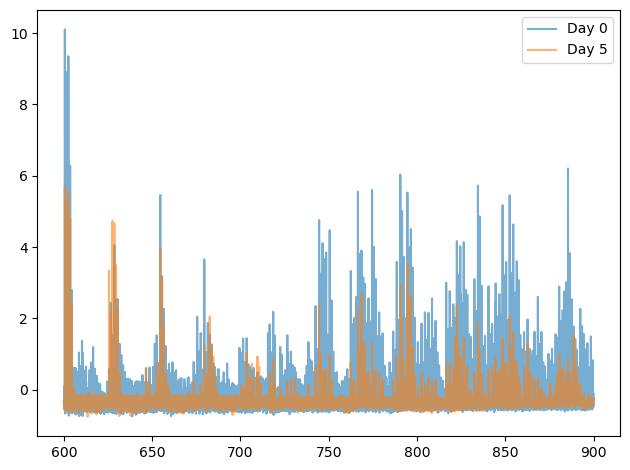

In [14]:
from tqdm.notebook import tqdm

means = {}

for img_idx in tqdm(range(0, len(samples_groups) * 2, 2)):
  vecs_0 = img_original_list[img_idx][seg_list[img_idx]]
  vecs_5 = img_original_list[img_idx + 1][seg_list[img_idx + 1]]

  means[img_idx] = np.median(vecs_0, axis=0)
  means[img_idx + 1] = np.median(vecs_5, axis=0)

  sample = np.array(samples_groups).flatten()[img_idx]
  brain, treatment, day = get_brain_id(sample), get_treatment(sample), get_day(sample)
  print(f"{brain}_{treatment}_{day}")

  plt.plot(mzs_list[0], means[img_idx], alpha=0.6, label="Day 0")
  plt.plot(mzs_list[0], means[img_idx+1], alpha=0.6, label="Day 5")
  plt.legend()
  plt.tight_layout()
  plt.show()

In [16]:
means_df = pd.DataFrame(means, index=mzs_list[0])
means_df.columns = means_df.columns.map(lambda x: np.array(samples_groups).flatten()[x]).map(lambda x: f"{get_brain_id(x)}_{get_treatment(x)}_{get_day(x)}")

In [23]:
corr = means_df.corr()
corr

,3_0_0,3_0_5,3_1000_0,3_1000_5,4_0_0,4_0_5,4_1000_0,4_1000_5,5_0_0,5_0_5,5_1000_0,5_1000_5,6_0_0,6_0_5,6_1000_0,6_1000_5
3_0_0,1.000000,0.835711,0.912768,0.647749,0.940188,0.776746,0.935480,0.759604,0.910259,0.785469,0.854561,0.647911,0.826618,0.775852,0.894375,0.682640
3_0_5,0.835711,1.000000,0.823391,0.824023,0.828547,0.904348,0.819602,0.871382,0.799057,0.877949,0.708702,0.734898,0.725258,0.890180,0.827809,0.677532
3_1000_0,0.912768,0.823391,1.000000,0.728034,0.925721,0.780009,0.929626,0.772088,0.919600,0.786335,0.827003,0.625746,0.837926,0.811854,0.898180,0.600615
3_1000_5,0.647749,0.824023,0.728034,1.000000,0.644804,0.910218,0.671516,0.903415,0.711519,0.842668,0.567081,0.731209,0.631668,0.889506,0.778855,0.612476
4_0_0,0.940188,0.828547,0.925721,0.644804,1.000000,0.733737,0.923600,0.724131,0.915271,0.740026,0.865540,0.560207,0.830002,0.755208,0.864209,0.588234
4_0_5,0.776746,0.904348,0.780009,0.910218,0.733737,1.000000,0.744015,0.957414,0.736739,0.930628,0.629349,0.854356,0.650569,0.925215,0.818840,0.799754
4_1000_0,0.935480,0.819602,0.929626,0.671516,0.923600,0.744015,1.000000,0.718665,0.925136,0.753006,0.875492,0.624510,0.890664,0.786456,0.921902,0.573594
4_1000_5,0.759604,0.871382,0.772088,0.903415,0.724131,0.957414,0.718665,1.000000,0.756665,0.930724,0.591789,0.779321,0.636075,0.868829,0.809496,0.765638
5_0_0,0.910259,0.799057,0.919600,0.711519,0.915271,0.736739,0.925136,0.756665,1.000000,0.780623,0.810968,0.578216,0.870315,0.779340,0.909174,0.580330
5_0_5,0.785469,0.877949,0.786335,0.842668,0.740026,0.930628,0.753006,0.930724,0.780623,1.000000,0.609389,0.811190,0.684672,0.886331,0.825754,0.810828


In [27]:
corrs_diff_no_treatment = [corr.loc["3_0_0", "3_0_5"],
corr.loc["4_0_0", "4_0_5"],
corr.loc["5_0_0", "5_0_5"],
corr.loc["6_0_0", "6_0_5"]]
corrs_diff_treatment= [
corr.loc["3_1000_0", "3_1000_5"],
corr.loc["4_1000_0", "4_1000_5"],
corr.loc["5_1000_0", "5_1000_5"],
corr.loc["6_1000_0", "6_1000_5"]
]

In [30]:
corrs_diff_no_treatment

[0.8357110485800455,
 0.7337374870301767,
 0.7806225391817383,
 0.7307730109339087]

In [31]:
pd.DataFrame.from_dict({
  'Correlation day 0 and day 5 no treatment': corrs_diff_no_treatment,
  'Correlation day 0 and day 5 with treatment': corrs_diff_treatment
})

,Correlation day 0 and day 5 no treatment,Correlation day 0 and day 5 with treatment
0,0.835711,0.728034
1,0.733737,0.718665
2,0.780623,0.522293
3,0.730773,0.660747


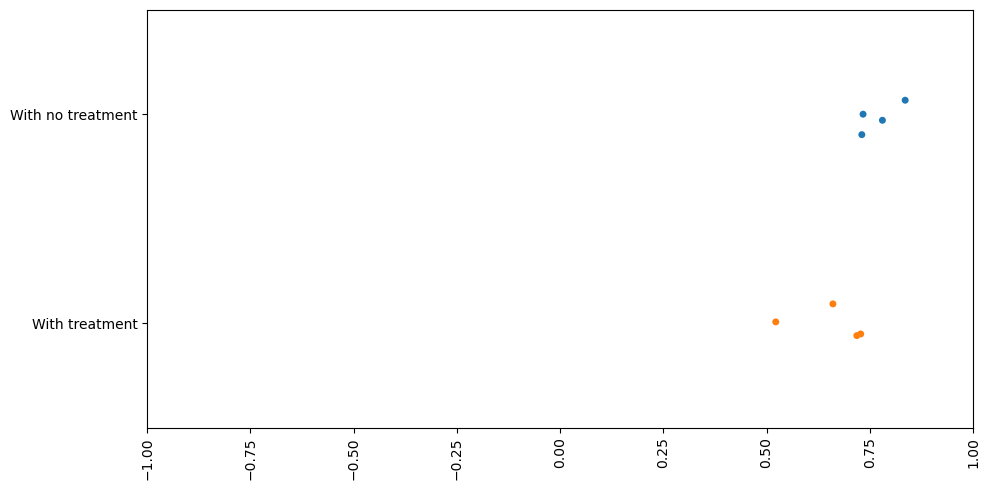

In [60]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.stripplot(data=pd.DataFrame.from_dict({
  'With no treatment': corrs_diff_no_treatment,
  'With treatment': corrs_diff_treatment
}), orient='h', jitter=True, ax=ax)
plt.xlim(-1, 1)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

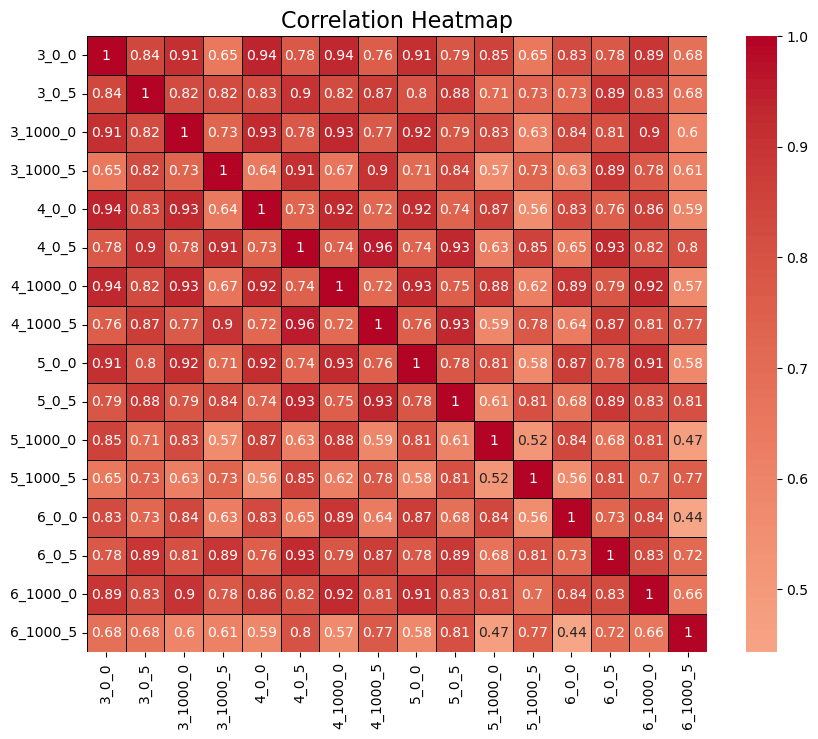

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(means_df.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5, linecolor='black')

# Add title and labels
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

